# Training models

## Imports

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from data_preprocessing import (
    full_pipeline,
    split_classif_reg_targets,
)
from random_forest import run_experiment as run_random_forest_experiment
from random_forest import benchmark_random_forest
from two_stage import run_experiment as run_two_stage_experiment
from two_stage import benchmark_2s_model_grid, benchmark_2s_param_grid
from xg_boost import run_experiment as run_xgboost_experiment
from xg_boost import benchmark_xgboost
from nn import run_experiment as run_nn_experiment
from nn import  submit_nn
from linreg import run_experiment as run_linreg_experiment
from utils import write_submissions, evaluate_model, stratify_by_humidity
import torch

## Load and prepare data

In [2]:
data_dir = "./data/"
train_x_path = os.path.join(data_dir, "x_train_T9QMMVq.csv")
train_y_path = os.path.join(data_dir, "y_train_R0MqWmu.csv")
test_x_path = os.path.join(data_dir, "x_test_9F13O5s.csv")

In [ ]:
params_pipeline = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.75,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 2,
    "include_group_interactions": True,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

test_params_pipeline = params_pipeline.copy()
test_params_pipeline["split"] = False
test_params_pipeline["split_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline
)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline)

# Create stratified validation sets
# x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=5)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)
print("X val shape:", x_val.shape)
print("Y val shape:", y_val.shape)
print("---")
print("X test shape:", x_test.shape)
print("---")

X train shape: (163548, 14)
Y train shape: (163548, 23)
X val shape: (39385, 14)
Y val shape: (39385, 23)
---
X test shape: (134673, 14)
---


In [3]:
params_pipeline_feateng = {
    "split_humidity": True,
    "h_threshold": 0.211,
    "split": False,
    "val_proportion": 0.75,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": True,
    "polynomial_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": True,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

feat_eng = True
if feat_eng:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = full_pipeline(
        train_x_path, train_y_path, **params_pipeline_feateng
    )
    x_test_eng = full_pipeline(test_x_path, None, **params_pipeline_feateng)
else:
    x_train_eng, y_train_eng, x_val_eng, y_val_eng = x_train, y_train, x_val, y_val
    x_test_eng = x_test
print("Train shape:", x_train_eng.shape)
print("Val shape:", x_val_eng.shape)
assert x_train_eng.shape[1] == x_test_eng.shape[1], (
    f"x_train and x_test have different number of features: "
    f"{x_train_eng.shape[1]} != {x_test_eng.shape[1]}."
    f"'ID' in train: {('ID' in x_train_eng.columns)},"
    f"'ID' in test: {('ID' in x_test_eng.columns)}."
)

Train shape: (163548, 40)
Val shape: (39385, 40)


## Standard Regressors

### Random Forest Regressor

In [4]:
print("Basic Random Forest")
rf_model = run_random_forest_experiment(x_train, y_train, x_val, y_val)

Basic Random Forest
Training Weighted RMSE: 0.1161
Validation Weighted RMSE: 0.1556


In [21]:
print("Basic Random Forest with Feature Engineering")
rf_model_eng = run_random_forest_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng)

Basic Random Forest with Feature Engineering
Training Weighted RMSE: 0.1108
Validation Weighted RMSE: 0.1455


In [24]:
x_train_eng.columns

Index(['ID', 'Humidity', 'M12', 'M13', 'M14', 'M15', 'M4', 'M5', 'M6', 'M7',
       'R', 'S1', 'S2', 'S3', 'Humidity_squared', 'Humidity_sqrt',
       'Humidity_M12_product', 'Humidity_M13_product', 'Humidity_M14_product',
       'Humidity_M15_product', 'Humidity_M4_product', 'Humidity_M5_product',
       'Humidity_M6_product', 'Humidity_M7_product', 'Humidity_R_product',
       'Humidity_S1_product', 'Humidity_S2_product', 'Humidity_S3_product',
       'Humidity_M12_ratio', 'Humidity_M13_ratio', 'Humidity_M14_ratio',
       'Humidity_M15_ratio', 'Humidity_M4_ratio', 'Humidity_M5_ratio',
       'Humidity_M6_ratio', 'Humidity_M7_ratio', 'Humidity_R_ratio',
       'Humidity_S1_ratio', 'Humidity_S2_ratio', 'Humidity_S3_ratio'],
      dtype='object')

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [7, 10, 15, None],
    "min_samples_split": [0.005, 0.01, 0.02],
    "min_samples_leaf": [20, 30, 50],
}
benchmark = False
if benchmark:
    try:
        best_model_rf, best_params_rf, best_val_rmse_rf = benchmark_random_forest(
            x_train,
            y_train,
            x_val,
            y_val,
            param_grid=param_grid,
            verbose=False,
            subset_humidity=False,
        )
    except KeyboardInterrupt:
        print("KeyboardInterrupt: Stopping the benchmarking process.")

In [4]:
best_params = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 0.005,
    "min_samples_leaf": 20,
    "random_state": 29,
    "n_jobs": -1,
}

best_rf_model = run_random_forest_experiment(
    x_train, y_train, x_val, y_val, params=best_params
)

Training Weighted RMSE: 0.0687
Validation Weighted RMSE: 0.1169


### XGBoost

In [5]:
param_grid = {
    "n_estimators": [100],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    # "min_child_weight": [5, 10, 15],
    # "gamma": [0, 0.1, 0.2],
    # "reg_alpha": [0, 0.1, 0.2],
    # "reg_lambda": [1, 1.5, 2],
}
benchmark=False
if benchmark:
    best_xgb_model, best_xgb_params, best_val_rmse_xgb = benchmark_xgboost(
        x_train,
        y_train,
        x_val,
        y_val,
        param_grid=param_grid,
        verbose=False,
        subset_humidity=False,
    )

In [4]:
print(best_xgb_params)
print(best_val_rmse_xgb)

{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 29, 'n_jobs': -1, 'tree_method': 'approx', 'max_bin': 64, 'scale_pos_weight': 1, 'process_type': 'default', 'predictor': 'cpu_predictor', 'grow_policy': 'depthwise'}
0.03559214381771881


In [6]:
params = {
    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 29,
    "n_jobs": -1,
}
try:
    xgb = run_xgboost_experiment(x_train, y_train, x_val, y_val, params=params)
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training.")

Training Weighted RMSE (XGBoost): 0.0218
Validation Weighted RMSE (XGBoost): 0.0379


### Multi Linear Regression with feature selection

In [ ]:
try:
    linear_model = run_linreg_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng, alpha=0.05)
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Train shape: (163548, 182)
Val shape: (39385, 182)
Training SelectiveLinearRegressor model...


  4%|▍         | 1/23 [00:09<03:39,  9.97s/it]

KeyboardInterrupt received. Stopping training.


In [26]:
try:
    linear_model = run_linreg_experiment(x_train_eng, y_train_eng, x_val_eng, y_val_eng, alpha=0.05)
except KeyboardInterrupt:
    print("KeyboardInterrupt received. Stopping training.")

Training SelectiveLinearRegressor model...


 61%|██████    | 14/23 [00:06<00:04,  2.05it/s]/Users/kiki/.pyenv/versions/idgaz/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Feature selection results:
c01: 37 features selected - R^2 before selection: 0.6581573911363705 - R^2 after selection: 0.6581461253456412
c02: 35 features selected - R^2 before selection: 0.19957698856481 - R^2 after selection: 0.19922571629176344
c03: 35 features selected - R^2 before selection: 0.48478437860224344 - R^2 after selection: 0.4847664062661967
c04: 35 features selected - R^2 before selection: 0.48478437860224344 - R^2 after selection: 0.4847664062661967
c05: 39 features selected - R^2 before selection: 0.33020189468184 - R^2 after selection: 0.33020189468184
c06: 39 features selected - R^2 before selection: 0.33020189468184 - R^2 after selection: 0.33020189468184
c07: 35 features selected - R^2 before selection: 0.19957698856481 - R^2 after selection: 0.19922571629176344
c08: 36 features selected - R^2 before selection: 0.14681788610167879 - R^2 after selection: 0.14675225582382345
c09: 36 features selected - R^2 before selection: 0.22648060651664526 - R^2 after selection

100%|██████████| 23/23 [00:00<00:00, 149.56it/s]

Training Weighted RMSE: 0.1643
Validation Weighted RMSE: 0.1721


In [ ]:
evaluate_model(linear_model, x_val_eng, y_val_eng)

100%|██████████| 23/23 [00:00<00:00, 53.57it/s]


0.13396921310406534

In [9]:
write_submissions(
    linear_model,
    test_x_path,
    "submissions_multi_regression_feateng.csv",
    use_embed=False,
    **params_pipeline_feateng,
)

Using 181 features


100%|██████████| 23/23 [00:03<00:00,  6.03it/s]


## Deep Learning

### Rescale data

In [3]:
params_pipeline_dl = {
    "split_humidity": False,
    "h_threshold": 0.211,
    "split": True,
    "val_proportion": 0.10,
    "rescale": False,
    "reduce_features": False,
    "augment": False,
    "apply_feat_eng": False,
    "polynomial_degree": 1,
    "include_group_interactions": False,
    "include_humidity_interactions": False,
    "feature_selection": False,
    "k_features": 30,
    "remove_outliers": False,
    "k": 10.0,
    "binarize_humidity": False,
    "n_bins": 5,
    "remove_humidity": False,
}

test_params_pipeline_dl = params_pipeline_dl.copy()
test_params_pipeline_dl["split"] = False
test_params_pipeline_dl["split_humidity"] = False

x_train, y_train, x_val, y_val = full_pipeline(
    train_x_path, train_y_path, **params_pipeline_dl
)
x_test = full_pipeline(test_x_path, None, **test_params_pipeline_dl)
print("Train shape:", x_train.shape)
print("Val shape:", x_val.shape)

Train shape: (182639, 14)
Val shape: (20294, 14)


In [15]:
x_val_strata, y_val_strata, labels = stratify_by_humidity(x_val, y_val, n_strata=2)
val_data = [(x_val_strata[i], y_val_strata[i]) for i in range(len(x_val_strata))]

In [16]:
labels

['H in [0.00, 0.01]', 'H in [0.01, 0.95]']

### RAMTNet

In [17]:
epochs = 20
params_ramt = {
    "model_class": "RAMTNet",
    "model_params": {
        "num_features": x_train.drop(columns=["ID"]).shape[1],
        "num_tasks": y_train.shape[1],
        "feature_embed_dim": 8,
        "embed_dim": 64,
        "attn_heads": 1,
        "attn_blocks": 1,
        "num_res_blocks": 1,
        "head_hidden": 32,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": 40,
        "lr": 1e-3,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": epochs // 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

In [ ]:
try:
    ramtnet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        params=params_ramt,
        uda=False,
        verbose=True,
        plot_losses=True,
        labels=labels,
        lambda_domain=0.25,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

Number of trainable parameters: 64407


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40 - Train Loss: 0.1519, Val Loss: 0.1107, LR: 0.001000:   2%|▎         | 1/40 [00:27<18:06, 27.85s/it]

In [24]:
error = evaluate_model(ramtnet, x_val, y_val)
print(f"Validation error: {error}")

Validation error: 0.23364904580516174


In [ ]:
torch.save(ramtnet.state_dict(), "checkpoints/ramtnet_base.pth")

### RegressorV3

Number of trainable parameters: 21775


Epoch 10/10 - Train Disc Acc: 59.45%, Train Disc Loss: 0.6611, Train Reg Loss: 0.1401, Train Loss: 0.3054, Val Loss: 0.2218, LR: 0.000063: 100%|██████████| 10/10 [02:03<00:00, 12.31s/it]


Final Validation Weighted RMSE: 0.2218


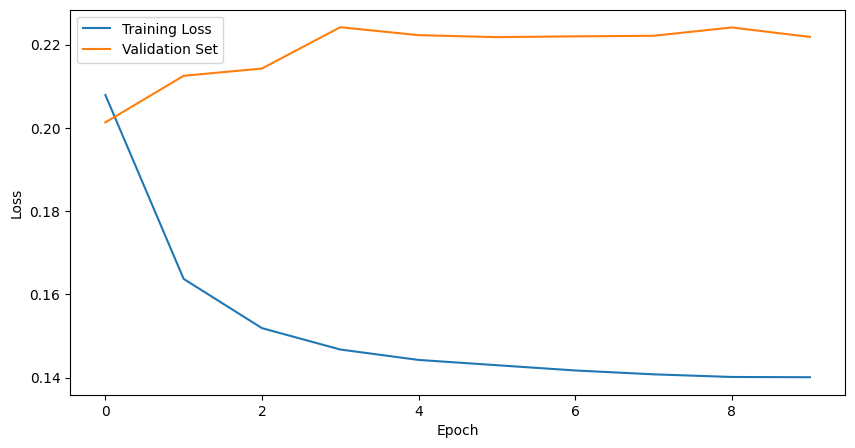

In [ ]:
params_reg_v3 = {
    "model_class": "RegressorV3",
    "model_params": {
        "hidden_dim": 32,
        "num_output": 23,
        "humidity_dim": 8,
        "group_embed_dim": 64,
        "bias": True,
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-4,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}
try:
    reg_v3 = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_reg_v3,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [26]:
print(f"Weighted RMSE on validation set: {evaluate_model(reg_v3, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.2545


In [ ]:
torch.save(reg_v3.state_dict(), "checkpoints/reg_v3_base.pth")

### NNRegressor

Number of trainable parameters: 41111


  0%|          | 0/100 [00:05<?, ?it/s]


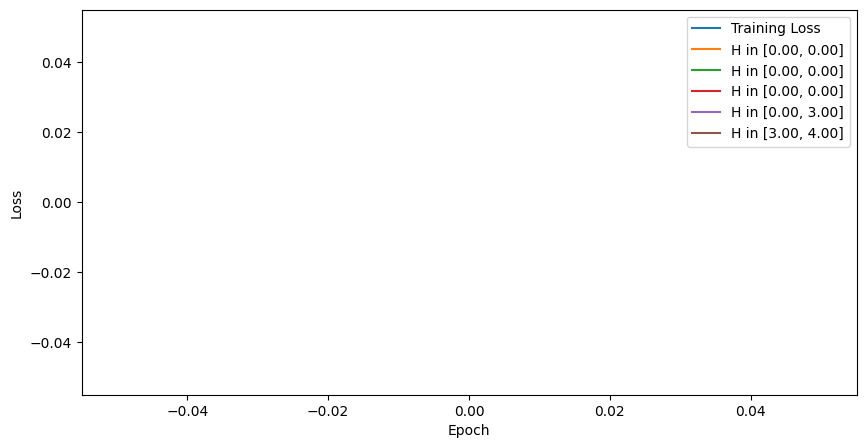

In [6]:
params_nnreg = {
    "model_class": "NNRegressor",
    "model_params": {
        "hidden_dim": 256,
        "num_output": 23,
        "bias": True,
        "dropout_rate": 0.3,
    },
    "training_params": {
        "n_epochs": 100,
        "lr": 1e-2,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": 10,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}

try:
    nnreg = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_nnreg,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [7]:
print(f"Weighted RMSE on validation set: {evaluate_model(nnreg, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.0811


In [ ]:
torch.save(nnreg.state_dict(), "checkpoints/nnreg_base.pth")

### GasDetectionModel

Number of trainable parameters: 3791


Epoch 10/10 - Train Loss: 0.0917, Val Loss: 0.2322, LR: 0.002500: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Final Validation Weighted RMSE: 0.2322


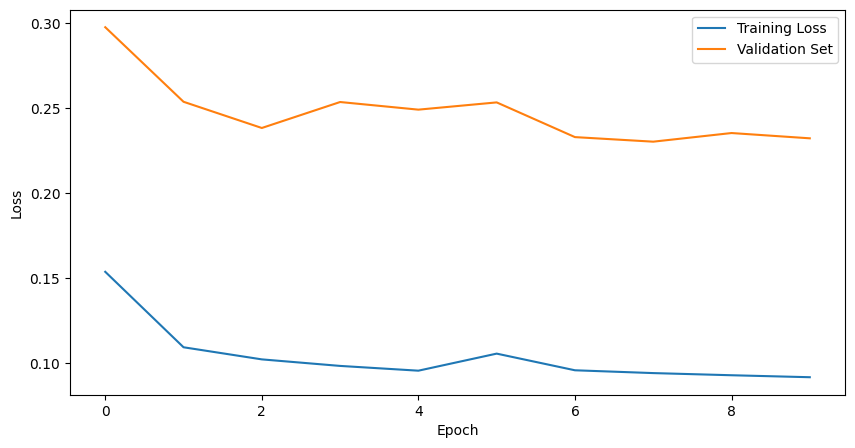

In [9]:
params_gasdet = {
    "model_class": "GasDetectionModel",
    "model_params": {
        "hidden_dim": 32,
        "num_output": 23,
        "dropout_rate": 0.1,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 256,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-6,
        "loss": "WeightedRMSELoss",
    },
}

try:
    gasdet = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        [(x_val, y_val)],
        uda=False,
        params=params_gasdet,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=None,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

In [30]:
print(f"Weighted RMSE on validation set: {evaluate_model(gasdet, x_val, y_val):.4f}")

Weighted RMSE on validation set: 0.2371


In [ ]:
torch.save(gasdet.state_dict(), "checkpoints/gasdet_base.pth")

### CNN

Number of trainable parameters: 70135


Epoch 10/10 - Train Loss: 0.2172, Val Loss: 0.2160, LR: 0.001250: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


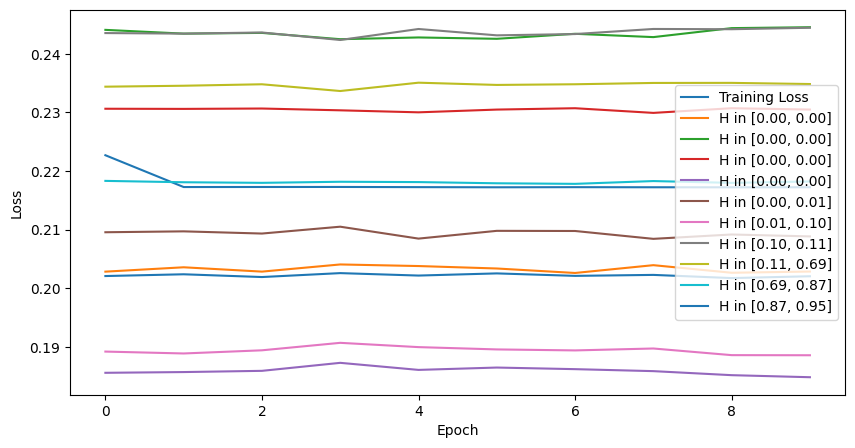

In [14]:
params_cnn = {
    "model_class": "SensorCNN",
    "model_params": {
        "input_dim": 13,
        "embed_dim": 32,
        "conv_channels": 64,
        "final_dim": 32,
        "num_output": 23,
    },
    "training_params": {
        "n_epochs": 10,
        "lr": 5e-3,
        "weight_decay": 1e-5,
        "batch_size": 128,
        "patience": 2,
        "factor": 0.5,
        "min_lr": 1e-7,
        "loss": "WeightedRMSELoss",
    },
}
try:
    cnn = run_nn_experiment(
        x_train,
        y_train,
        x_test,
        val_data,
        uda=False,
        params=params_cnn,
        lambda_domain=0.25,
        verbose=True,
        plot_losses=True,
        labels=labels,
        zero_weight=1.0,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping training early.")

## Two-stage approach

In [4]:
y_train_classif, y_train_reg = split_classif_reg_targets(y_train)
y_val_classif, y_val_reg = split_classif_reg_targets(y_val)

In [5]:
model_grid = {
    "clf_names": ['randomforestclassifier', 'decisiontreeclassifier', 'kneighborsclassifier', 'xgbclassifier'],
    "reg_names": ['randomforestregressor', 'linearregression', 'decisiontreeregressor', 'kneighborsregressor', 'xgbregressor', 'gradientboostingregressor'],
    "clf_params": {
        "randomforestclassifier": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "decisiontreeclassifier": {"max_depth": 10, "random_state": 29},
        "kneighborsclassifier": {"n_neighbors": 5, "n_jobs": -1},
        "xgbclassifier": {"n_estimators": 10, "max_depth": 10, "random_state": 29},
    },
    "reg_params": {
        "randomforestregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "linearregression": {"n_jobs": -1},
        "decisiontreeregressor": {"max_depth": 10, "random_state": 29},
        "kneighborsregressor": {"n_neighbors": 5, "n_jobs": -1},
        "xgbregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29, "n_jobs": -1},
        "gradientboostingregressor": {"n_estimators": 10, "max_depth": 10, "random_state": 29},
    }
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_model_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        model_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

Model Grid Search:   4%|▍         | 1/24 [00:09<03:32,  9.24s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0491
Validation Weighted RMSE: 0.0899
--------------------------------------------------


Model Grid Search:   8%|▊         | 2/24 [00:14<02:37,  7.17s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1213
Validation Weighted RMSE: 0.1480
--------------------------------------------------


Model Grid Search:  12%|█▎        | 3/24 [00:22<02:34,  7.36s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0549
Validation Weighted RMSE: 0.0971
--------------------------------------------------


Model Grid Search:  17%|█▋        | 4/24 [00:31<02:36,  7.81s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0307
Validation Weighted RMSE: 0.0734
--------------------------------------------------


Model Grid Search:  21%|██        | 5/24 [00:39<02:30,  7.94s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0322
Validation Weighted RMSE: 0.0712
--------------------------------------------------


Model Grid Search:  25%|██▌       | 6/24 [01:00<03:44, 12.46s/it]


Model Combination: Classifier 'randomforestclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0663
Validation Weighted RMSE: 0.0935
--------------------------------------------------


Model Grid Search:  29%|██▉       | 7/24 [01:08<03:07, 11.05s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0554
Validation Weighted RMSE: 0.0927
--------------------------------------------------


Model Grid Search:  33%|███▎      | 8/24 [01:13<02:27,  9.23s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1235
Validation Weighted RMSE: 0.1480
--------------------------------------------------


Model Grid Search:  38%|███▊      | 9/24 [01:20<02:07,  8.53s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0607
Validation Weighted RMSE: 0.0994
--------------------------------------------------


Model Grid Search:  42%|████▏     | 10/24 [01:29<01:57,  8.39s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0405
Validation Weighted RMSE: 0.0774
--------------------------------------------------


Model Grid Search:  46%|████▌     | 11/24 [01:35<01:42,  7.92s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0413
Validation Weighted RMSE: 0.0745
--------------------------------------------------


Model Grid Search:  50%|█████     | 12/24 [01:56<02:21, 11.76s/it]


Model Combination: Classifier 'decisiontreeclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0705
Validation Weighted RMSE: 0.0947
--------------------------------------------------


Model Grid Search:  54%|█████▍    | 13/24 [05:48<14:23, 78.54s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0438
Validation Weighted RMSE: 0.0738
--------------------------------------------------


Model Grid Search:  58%|█████▊    | 14/24 [09:36<20:37, 123.77s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1195
Validation Weighted RMSE: 0.1401
--------------------------------------------------


Model Grid Search:  62%|██████▎   | 15/24 [13:35<23:46, 158.52s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0503
Validation Weighted RMSE: 0.0827
--------------------------------------------------


Model Grid Search:  67%|██████▋   | 16/24 [17:36<24:25, 183.20s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0202
Validation Weighted RMSE: 0.0488
--------------------------------------------------


Model Grid Search:  71%|███████   | 17/24 [21:27<23:02, 197.49s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0226
Validation Weighted RMSE: 0.0465
--------------------------------------------------


Model Grid Search:  75%|███████▌  | 18/24 [25:32<21:11, 211.89s/it]


Model Combination: Classifier 'kneighborsclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0624
Validation Weighted RMSE: 0.0782
--------------------------------------------------


Model Grid Search:  79%|███████▉  | 19/24 [25:59<13:02, 156.41s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'randomforestregressor'
Training Weighted RMSE: 0.0431
Validation Weighted RMSE: 0.0717
--------------------------------------------------


Model Grid Search:  83%|████████▎ | 20/24 [26:25<07:48, 117.07s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'linearregression'
Training Weighted RMSE: 0.1193
Validation Weighted RMSE: 0.1387
--------------------------------------------------


Model Grid Search:  88%|████████▊ | 21/24 [26:52<04:30, 90.01s/it] 


Model Combination: Classifier 'xgbclassifier' | Regressor 'decisiontreeregressor'
Training Weighted RMSE: 0.0497
Validation Weighted RMSE: 0.0809
--------------------------------------------------


Model Grid Search:  92%|█████████▏| 22/24 [27:21<02:23, 71.94s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'kneighborsregressor'
Training Weighted RMSE: 0.0187
Validation Weighted RMSE: 0.0449
--------------------------------------------------


Model Grid Search:  96%|█████████▌| 23/24 [27:49<00:58, 58.75s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'xgbregressor'
Training Weighted RMSE: 0.0214
Validation Weighted RMSE: 0.0422
--------------------------------------------------


Model Grid Search: 100%|██████████| 24/24 [28:32<00:00, 71.34s/it]


Model Combination: Classifier 'xgbclassifier' | Regressor 'gradientboostingregressor'
Training Weighted RMSE: 0.0620
Validation Weighted RMSE: 0.0756
--------------------------------------------------

Best Model:
Parameters: {'clf_name': 'xgbclassifier', 'reg_name': 'xgbregressor', 'clf_params': {'n_estimators': 10, 'max_depth': 10, 'random_state': 29}, 'reg_params': {'n_estimators': 10, 'max_depth': 10, 'random_state': 29, 'n_jobs': -1}}
Validation RMSE: 0.0422
Best Model Performance on validation set:
Validation RMSE: 0.0422


In [11]:
clf_name = "kneighborsclassifier"
reg_name = "randomforestregressor"
param_grid = {
    "clf": {
        'n_neighbors': [5], 'weights': ['uniform'], 'algorithm': ['auto'],
    },
    "reg": {
        "n_estimators": [100, 200],
        "max_depth": [7, 10, 15],
        "min_samples_split": [0.005, 0.01],
        "min_samples_leaf": [30, 50],
    },
}

try:
    best_model_2s, best_params_2s, best_val_rmse_2s = benchmark_2s_param_grid(
        x_train,
        y_train,
        y_train_classif,
        y_train_reg,
        x_val,
        y_val,
        y_val_classif,
        y_val_reg,
        clf_name,
        reg_name,
        param_grid,
        verbose=True,
    )
except KeyboardInterrupt:
    print("KeyboardInterrupt: Stopping the benchmarking process.")

Hyperparameter Search:   4%|▍         | 1/24 [05:10<1:58:57, 310.34s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0762
Validation Weighted RMSE: 0.1005
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:   8%|▊         | 2/24 [10:11<1:51:52, 305.11s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0760
Validation Weighted RMSE: 0.1003
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  12%|█▎        | 3/24 [14:58<1:43:48, 296.59s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0791
Validation Weighted RMSE: 0.1040
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  17%|█▋        | 4/24 [21:09<1:48:39, 325.95s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0798
Validation Weighted RMSE: 0.1051
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  21%|██        | 5/24 [27:05<1:46:39, 336.84s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0583
Validation Weighted RMSE: 0.0933
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  25%|██▌       | 6/24 [33:57<1:48:44, 362.50s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0591
Validation Weighted RMSE: 0.0940
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  29%|██▉       | 7/24 [40:10<1:43:38, 365.82s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0669
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  33%|███▎      | 8/24 [46:30<1:38:44, 370.25s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1008
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  38%|███▊      | 9/24 [51:52<1:28:47, 355.18s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0523
Validation Weighted RMSE: 0.0876
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  42%|████▏     | 10/24 [57:14<1:20:32, 345.19s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0526
Validation Weighted RMSE: 0.0883
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  46%|████▌     | 11/24 [1:02:30<1:12:50, 336.20s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0649
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  50%|█████     | 12/24 [1:09:22<1:11:51, 359.29s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0651
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  54%|█████▍    | 13/24 [1:16:10<1:08:34, 374.06s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0760
Validation Weighted RMSE: 0.1002
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  58%|█████▊    | 14/24 [1:23:26<1:05:27, 392.73s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0761
Validation Weighted RMSE: 0.1002
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  62%|██████▎   | 15/24 [1:31:13<1:02:15, 415.10s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0794
Validation Weighted RMSE: 0.1045
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  67%|██████▋   | 16/24 [1:38:58<57:19, 429.92s/it]  


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0795
Validation Weighted RMSE: 0.1046
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  71%|███████   | 17/24 [1:46:55<51:49, 444.20s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0582
Validation Weighted RMSE: 0.0929
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  75%|███████▌  | 18/24 [1:54:53<45:26, 454.41s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0587
Validation Weighted RMSE: 0.0936
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  79%|███████▉  | 19/24 [2:02:47<38:21, 460.40s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1010
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  83%|████████▎ | 20/24 [2:10:12<30:22, 455.68s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0672
Validation Weighted RMSE: 0.1007
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  88%|████████▊ | 21/24 [2:18:23<23:18, 466.28s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0523
Validation Weighted RMSE: 0.0878
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  92%|█████████▏| 22/24 [2:27:00<16:03, 481.54s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0527
Validation Weighted RMSE: 0.0885
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search:  96%|█████████▌| 23/24 [2:36:19<08:24, 504.58s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 30, 'n_jobs': -1}
Training Weighted RMSE: 0.0647
Validation Weighted RMSE: 0.1007
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------


Hyperparameter Search: 100%|██████████| 24/24 [2:45:39<00:00, 414.14s/it]


Parameters:
 Classifier params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1} 
 Regressor params: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 0.01, 'min_samples_leaf': 50, 'n_jobs': -1}
Training Weighted RMSE: 0.0652
Validation Weighted RMSE: 0.1012
Validation Accuracy of Classifier: 0.9955
--------------------------------------------------

Best Model:
Best Parameters: {'clf_params': {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'n_jobs': -1}, 'reg_params': {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 30, 'n_jobs': -1}}
Validation RMSE: 0.0876
Validation Accuracy of Classifier: 0.9955


In [7]:
print(evaluate_model(best_model_2s, x_train, y_train))
print(evaluate_model(best_model_2s, x_val, y_val))

0.09126748525337898
0.11458981865327754


In [13]:
clf_params = {
    'n_neighbors': 5, 
    'weights': 'uniform', 
    'algorithm': 'auto', 'n_jobs': -1
}
reg_params = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 0.005, 'min_samples_leaf': 50, 'n_jobs': -1}

two_stage_rf = run_two_stage_experiment(
    x_train,
    y_train,
    y_train_classif,
    y_train_reg,
    x_val,
    y_val,
    y_val_classif,
    y_val_reg,
    clf_name="kneighborsclassifier",
    reg_name="randomforestregressor",
    clf_params=clf_params,
    reg_params=reg_params,
)

Training Weighted RMSE: 0.0534
Validation Weighted RMSE: 0.0888
Validation Accuracy of Classifier: 0.9955


## Predict

In [ ]:
write_submissions(
    xgb,
    test_x_path,
    "submissions/xgb_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

In [ ]:
write_submissions(
    best_rf_model,
    test_x_path,
    "submissions/rf_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

In [14]:
write_submissions(
    two_stage_rf,
    test_x_path,
    "submissions/two_stage_knn_rf_best.csv",
    use_embed=False,
    **test_params_pipeline,
)

Using 13 features


In [ ]:
params_pipeline_dl["split"] = False
params_pipeline_dl["split_humidity"] = False
submit_nn(
    "checkpoints/ramtnet_base.pth",
    "RAMTNet",
    params_ramt["model_params"],
    params_pipeline_dl,
    test_x_path,
    "submissions/ramtnet_base.csv",
)

# Project Restructuring Plan for IDGAZ


## 1. Create a Package Structure

Convert the flat file structure into a proper Python package with submodules:



In [ ]:
/Users/kiki/code/idgaz/
├── README.md                      # Project documentation
├── requirements.txt               # Dependencies
├── setup.py                       # Package setup
├── idgaz/                         # Main package
│   ├── __init__.py
│   ├── models/                    # All model implementations
│   │   ├── __init__.py
│   │   ├── linear.py              # Linear models
│   │   ├── tree_based.py          # RF and XGBoost models
│   │   ├── neural/                # Neural network models
│   │   │   ├── __init__.py
│   │   │   ├── architectures.py   # NN architectures
│   │   │   ├── losses.py          # Custom loss functions
│   │   │   ├── training.py        # Training loop functions
│   │   │   └── uda.py             # Unsupervised domain adaptation
│   ├── data/                      # Data processing
│   │   ├── __init__.py
│   │   ├── preprocessing.py       # Data preprocessing
│   │   └── feature_engineering.py # Feature engineering
│   ├── utils/                     # Utilities
│   │   ├── __init__.py
│   │   ├── evaluation.py          # Metrics and evaluation
│   │   ├── visualization.py       # Plotting and visualization
│   │   └── io.py                  # Data loading/saving
│   └── config/                    # Configuration
│       ├── __init__.py
│       └── default_config.py      # Default parameters
├── scripts/                       # Entry point scripts
│   ├── train.py                   # Training script
│   ├── evaluate.py                # Evaluation script
│   └── predict.py                 # Prediction script
├── notebooks/                     # Jupyter notebooks for analysis
│   └── eda.ipynb                  # EDA notebook
└── tests/                         # Unit tests
    └── __init__.py



## 2. Implementation Details

### File Migration and Refactoring

Here's how each existing file will be migrated:

1. **xg_boost.py** and **random_forest.py** → **idgaz/models/tree_based.py**
   - Consolidate tree-based models into one file
   - Create unified API for training and evaluation

2. **linreg.py** → **idgaz/models/linear.py**
   - Keep the SelectiveLinearRegressor implementation

3. **nn.py** → Split into:
   - **idgaz/models/neural/architectures.py** - NN model definitions
   - **idgaz/models/neural/losses.py** - Custom loss functions
   - **idgaz/models/neural/training.py** - Training loops

4. **residual_attention_net.py** → **idgaz/models/neural/architectures.py**
   - Move model architecture here

5. **uda.py** → **idgaz/models/neural/uda.py**
   - Keep domain adaptation code separate but organized

6. **two_stage_rf.py** → **idgaz/models/tree_based.py**
   - Integrate with other tree-based models

7. **data_preprocessing.py** → **idgaz/data/preprocessing.py**
   - Clean up and organize preprocessing functions

8. **feature_engineering.py** → **idgaz/data/feature_engineering.py**
   - Keep feature engineering functions

9. **utils.py** → Split into:
   - **idgaz/utils/evaluation.py** - Model evaluation functions
   - **idgaz/utils/io.py** - Data loading/saving

10. **eda_utils.py** → **idgaz/utils/visualization.py**
    - Consolidate visualization functions

### 3. Create Common Interfaces

1. Define common model interfaces for consistency:



In [ ]:
# idgaz/models/__init__.py
from abc import ABC, abstractmethod

class BaseModel(ABC):
    @abstractmethod
    def train(self, x_train, y_train, **kwargs):
        """Train the model"""
        pass
    
    @abstractmethod
    def predict(self, x):
        """Make predictions"""
        pass
    
    @abstractmethod
    def evaluate(self, x_val, y_val):
        """Evaluate the model"""
        pass
    
    @abstractmethod
    def save(self, path):
        """Save the model"""
        pass
    
    @abstractmethod
    def load(self, path):
        """Load the model"""
        pass



### 4. Implementation Plan

1. Create the directory structure
2. Set up basic package files (__init__.py, setup.py)
3. Begin refactoring files one by one, starting with core functionality
4. Create entry point scripts
5. Add documentation to functions
6. Test the refactored code

Would you like me to provide more details about implementing any specific part of this restructuring?